<a href="https://colab.research.google.com/github/EmilyBoland/Syntaxin-EESM-Analysis/blob/master/Cleaned_work_analysis_with_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessing, Importing, and Tallying Data



Give Access to Drive and Import Packages/Functions/Data



In [40]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import entropy
import json
import sys
import matplotlib.gridspec as gridspec

sys.path.append('/content/drive/My Drive/Kasson lab/Polished Syntaxin Code')
import work_analysis_functions as waf

alldata = json.load(open('Kasson lab/Polished Syntaxin Code/all_data_11_17_2020.json'))
finaldata = json.load(open('Kasson lab/Polished Syntaxin Code/final_ensemble.json'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive




Create Dictionaries to Keep Track of Data



In [41]:
# target_to_mem_dict connects targets to members = {'d1,d2,d3': [mem_n], 'd1,d2,d3': [mem_i, mem_j],...}
# mem_to_target-dict connects members to targets = {'mem_n': 'd1,d2,d3',...}
# run_tally counts the number of runs per target set = {target set: number of runs, target set: ...}
# missing_runs connects a list simulation runs that were never initiated to a target set. There should be ten runs per member = {target_set:[runi, runj], target_set:...}
# complete_runs connects a list of simulation runs that were intiated to each target set {target_set:[runi, runj], target_set:...}

target_dict = alldata['targets']

target_to_mem_dict = {}
mem_to_target_dict = {}
for mem in target_dict: 
  target_set = str(target_dict[mem]['052_210']) + ',' + str(target_dict[mem]['105_216']) + ',' + str(target_dict[mem]['196_228'])
  if target_set in target_to_mem_dict.keys():
    target_to_mem_dict[target_set].append(mem)
  else: 
    target_to_mem_dict[target_set] = [mem]
  mem_to_target_dict[mem] = target_set


run_tally = {}
for target in target_to_mem_dict: 
  tally = 0
  for mem in target_to_mem_dict[target]:
    tally += len(alldata['initial states'][mem])
  run_tally[target] = tally 


missing_runs = {}
for mem in alldata['initial states']:
  for run in range(1,11):
    try:
      a = alldata['initial states'][mem][str(run)]
    except: 
      target_set = mem_to_target_dict[mem]
      if target_set in missing_runs.keys(): 
        missing_runs[target_set].append(run)
      else: 
        missing_runs[target_set] = [run]


completed_runs = {}
for mem in alldata['initial states']: 
  target_set = mem_to_target_dict[mem]
  completed_runs[target_set] = []
  for run in alldata['initial states'][mem]:
    completed_runs[target_set].append(int(run))



# Calculating Work and Obtaining Probabilities



Calculate and Threshold Work



In [42]:
# work_values contains all work values for a given target set: {"d1,d2,d3":[w1,w2,...],...}
# work_values_by_run contains all work values for a single run for a given target set: {run: {"d1,d2,d3":[w1,w2,...],...}, ...} for converged runs only

work_values = {}
work_values_by_run = {1:{},2:{},3:{},4:{},5:{},6:{},7:{},8:{},9:{},10:{}}
  
for mem in alldata['converged run data']:
  for run in alldata['converged run data'][mem]:
    key = str(alldata['converged run data'][mem][run]["052_210"]['target'])+','+str(alldata['converged run data'][mem][run]["105_216"]['target'])+','+str(alldata['converged run data'][mem][run]["196_228"]['target'])
    work = waf.calc_work(alldata, mem, run)
    
    if key in work_values.keys():
      work_values[key].append(work)
    else: 
      work_values[key] = [work]

    if key in work_values_by_run[int(run)].keys():
      work_values_by_run[int(run)][key].append(work)
    else: 
      work_values_by_run[int(run)][key] = [work]
    

threshold_val = 300
thresholded_data = waf.threshold(threshold_val, work_values, work_values_by_run)
work_values = thresholded_data['work_values']
work_values_by_run = thresholded_data['work_values_by_run']



Account for nonconverged runs 



In [43]:
# adds in infinite work values for unconverged runs as string 'INF'
  # work_values is formatted the same, but the values (lists of work estimate calculations) will have length multiple of 10

for target_set in target_to_mem_dict:
  if target_set not in work_values.keys():
    work_values[target_set] = ['INF']

for target_set in work_values: 
  num_runs = len(completed_runs[target_set])
  for run in range(num_runs-len(work_values[target_set])):
    work_values[target_set].append('INF')


Create Work Dictionaries with Cumulative Work Values



In [44]:
# creates 1 dictionary with work calculations through runs (cumulative): 
  # work_values_through_trials contains all work values (including infinite work) for all runs up to and including the key run: {run: {"d1,d2,d3":[w1,w2,...],...}, ...}
    # ex: work_values_through_trials[5]["d1,d2,d3"] contains the work values from runs 1-5 where the target set was "d1,d2,d3"

work_values_through_runs = {1:{},2:{},3:{},4:{},5:{},6:{},7:{},8:{},9:{},10:{}}

for target_set in completed_runs: 
  for run in range(1,11):
    work_values_through_runs[run][target_set] = []
    for comp_run in completed_runs[target_set]:
      if comp_run <= run: 
        if target_set in work_values_by_run[comp_run].keys():
          work_values_through_runs[run][target_set] += work_values_by_run[comp_run][target_set]
        else: 
          work_values_through_runs[run][target_set].append("INF")



Implement Jarzynski Equation



In [45]:
# implements Jarzynski Equation on all runs to all runs of all target sets to find average e^(-beta*W) = e^(-beta*deltaG)

jarz_work_dict = {}
for target_set in work_values: 
  w_vals = work_values[target_set]
  jarz_work = waf.average_jarz_work(w_vals)
  jarz_work_dict[target_set] = jarz_work


# implements Jarzynski Equation to find average exponential work through trials

jarz_work_through_runs = {1:{},2:{},3:{},4:{},5:{},6:{},7:{},8:{},9:{},10:{}}
for run in jarz_work_through_runs:
  for target_set in work_values_through_runs[run]:
    w_vals = work_values_through_runs[run][target_set]
    exp_work = waf.average_jarz_work(w_vals)
    jarz_work_through_runs[run][target_set] = exp_work




Normalize Probabilities



In [46]:
normalized_probs = waf.normalize_probs(jarz_work_dict)

probs_through_runs = {}
for run in jarz_work_through_runs: 
  probs_through_runs[run] = waf.normalize_probs(jarz_work_through_runs[run])

# Generating 2D Figures



Reformat and Plot Experimental Data



True

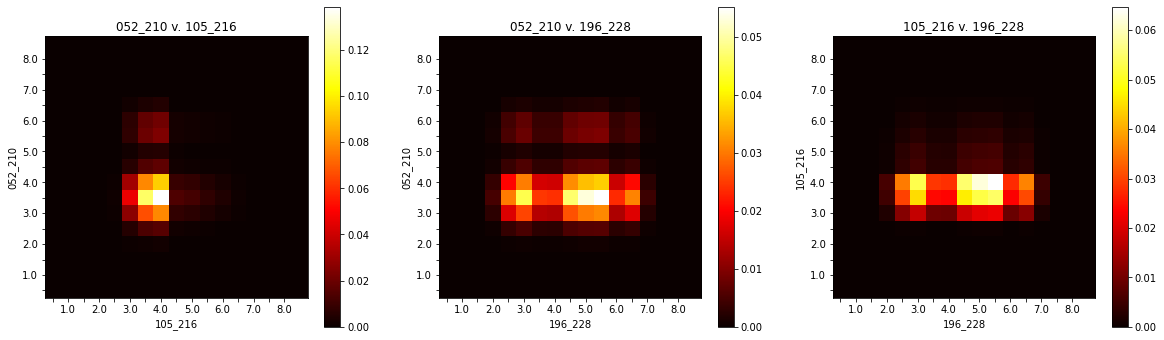

In [47]:
# this code is adapted from Jennifer Hays Wagner

exp_data = alldata['experimental data']
bins = exp_data["052_210"]["bins"]
nbins = len(bins) 

exp052_210 = waf.normalize_probs(exp_data["052_210"]["distribution"])
exp105_216 = waf.normalize_probs(exp_data["105_216"]["distribution"])
exp196_228 = waf.normalize_probs(exp_data["196_228"]["distribution"])

joint_exp = np.zeros(shape=(nbins, nbins, nbins))
for i in range(nbins):
  for j in range(nbins):
    for k in range(nbins):
      joint_exp[i,j,k] = exp052_210[i] * \
      exp105_216[j] * \
      exp196_228[k]

np.testing.assert_almost_equal(np.sum(joint_exp), 1)

exp_2D_dict = waf.twoD_sum(joint_exp)
exp_1D_dict = waf.oneD_sum(joint_exp)

waf.make_map(exp_2D_dict)


Plot Simulation Data

True

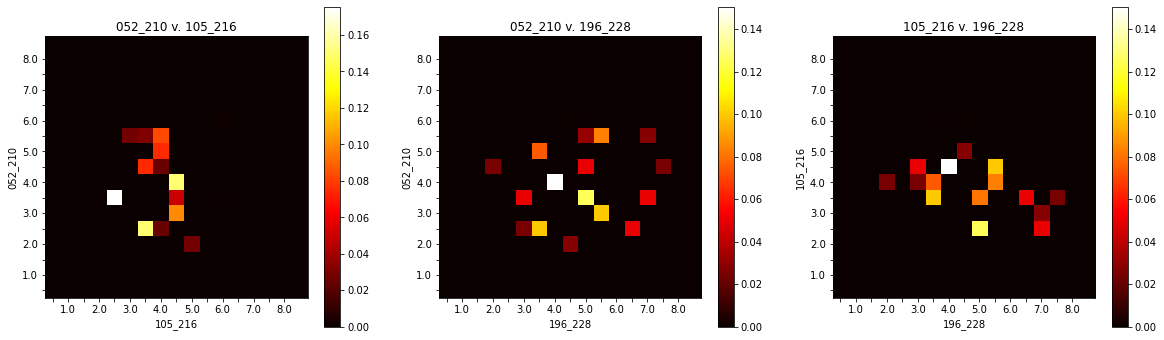

In [48]:
simdata = np.zeros(shape=(nbins,nbins,nbins))
for key in normalized_probs:   
  simdata[bins.index(float(key[0:3])), bins.index(float(key[4:7])), bins.index(float(key[8:11]))] += normalized_probs[key]

sim_2D_dict = waf.twoD_sum(simdata)
sim_1D_dict = waf.oneD_sum(simdata)

# np.save("EESM_joint_dist_11_19_2020.npy", simdata)

waf.make_map(sim_2D_dict)
# plt.savefig("EESM_output_2D.pdf")



Create Figures to Visualize Starting Conformations



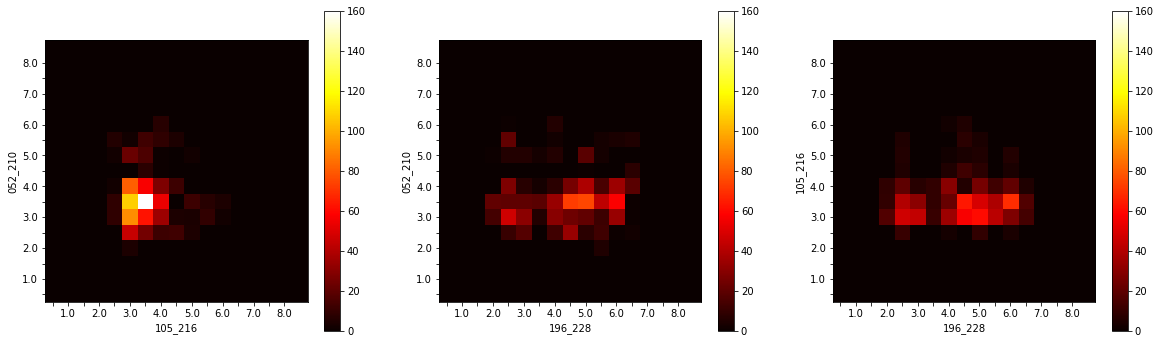

In [49]:
start_dict = alldata['initial states']

starting_confs = np.zeros(shape = (nbins,nbins,nbins))

for mem in start_dict: 
  for run in start_dict[mem]:
    try:
      starting_confs[np.digitize((start_dict[mem][run]['052_210']),bins)-1,np.digitize((start_dict[mem][run]['105_216']),bins)-1,np.digitize((start_dict[mem][run]['196_228']),bins)-1] += 1
    except:  # just a little sanity check to make sure I don't lose any data
      print("we have and error with {}, run {}: {}".format(mem, run, start_dict[mem][run]))

start_2D_dict = waf.twoD_sum(starting_confs)

fig = plt.figure(figsize = (20,20))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure = fig, wspace = 0.5)
i = 1
for key in start_2D_dict:
  fig.add_subplot(3,3,i)
  plt.imshow(start_2D_dict[key], 
             interpolation=None, 
             origin='lower', cmap= 'hot',
             vmin = 0, vmax = 160)
  plt.xlabel(key[9:])
  plt.ylabel(key[0:7])
  plt.colorbar()
  plt.xticks(np.arange(16), ('','1.0', '','2.0', '','3.0','', '4.0','', '5.0','','6.0','','7.0','','8.0'))
  plt.yticks(np.arange(16), ('','1.0', '','2.0', '','3.0','', '4.0','', '5.0','','6.0','','7.0','','8.0'))
  i += 1 



Creates Figures to Visualize Target Conformations

True

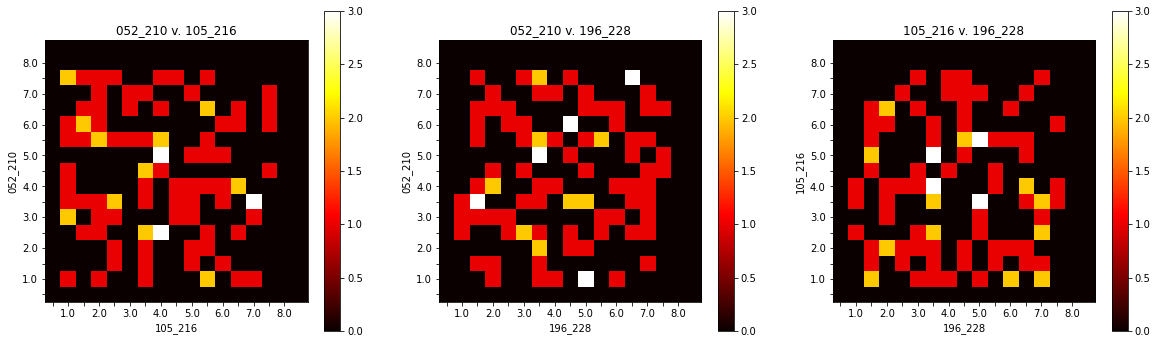

In [50]:
target_dict = alldata['targets']
target_confs = np.zeros(shape = (nbins, nbins, nbins))
for mem in target_dict: 
  target_confs[bins.index(target_dict[mem]['052_210']),bins.index(target_dict[mem]['105_216']),bins.index(target_dict[mem]['196_228'])] += 1

target_2D_dict = waf.twoD_sum(target_confs)
waf.make_map(target_2D_dict)


# Generating 1D Figures

Plot 1D Projections of Simulation and Experimental Data

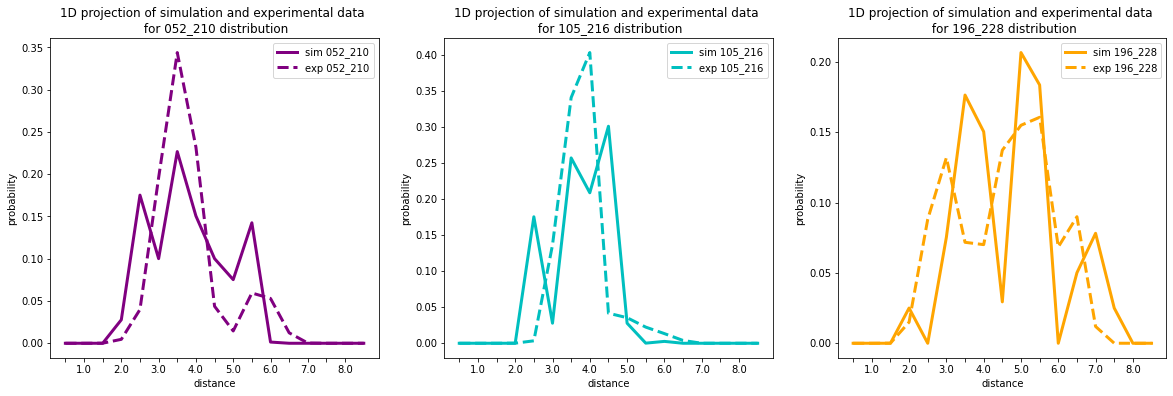

In [51]:
fig = plt.figure(figsize = (20,20))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure = fig, wspace = 0.5)
i = 1
for key in sim_1D_dict: 
  fig.add_subplot(3,3,i)
  colors = ['purple', 'c', 'orange']
  plt.plot(sim_1D_dict[key], color = colors[i-1], lw = 3)
  plt.plot(exp_1D_dict[key], color = colors[i-1], ls = '--', lw = 3)
  plt.xlabel("distance")
  plt.ylabel("probability") 
  plt.title("1D projection of simulation and experimental data \n for {} distribution".format(key, threshold_val))
  plt.xticks(np.arange(16), ('','1.0', '','2.0', '','3.0','', '4.0','', '5.0','','6.0','','7.0','','8.0'));
  plt.legend(['sim {}'.format(key), 'exp {}'.format(key)])
  i += 1

plt.savefig("1D_deer_and_eesm_11_19.pdf")


# Generating JS Divergence Figures

Plot JS Divergence Along Each Distribution

In [52]:
sim_v_exp_div052_210 = waf.JScalculator(sim_1D_dict['052_210'],exp_1D_dict['052_210'])
sim_v_exp_div105_216 = waf.JScalculator(sim_1D_dict['105_216'],exp_1D_dict['105_216'])
sim_v_exp_div196_228 = waf.JScalculator(sim_1D_dict['196_228'],exp_1D_dict['196_228'])


Plot JS Divergence Along Runs (Cumulative)

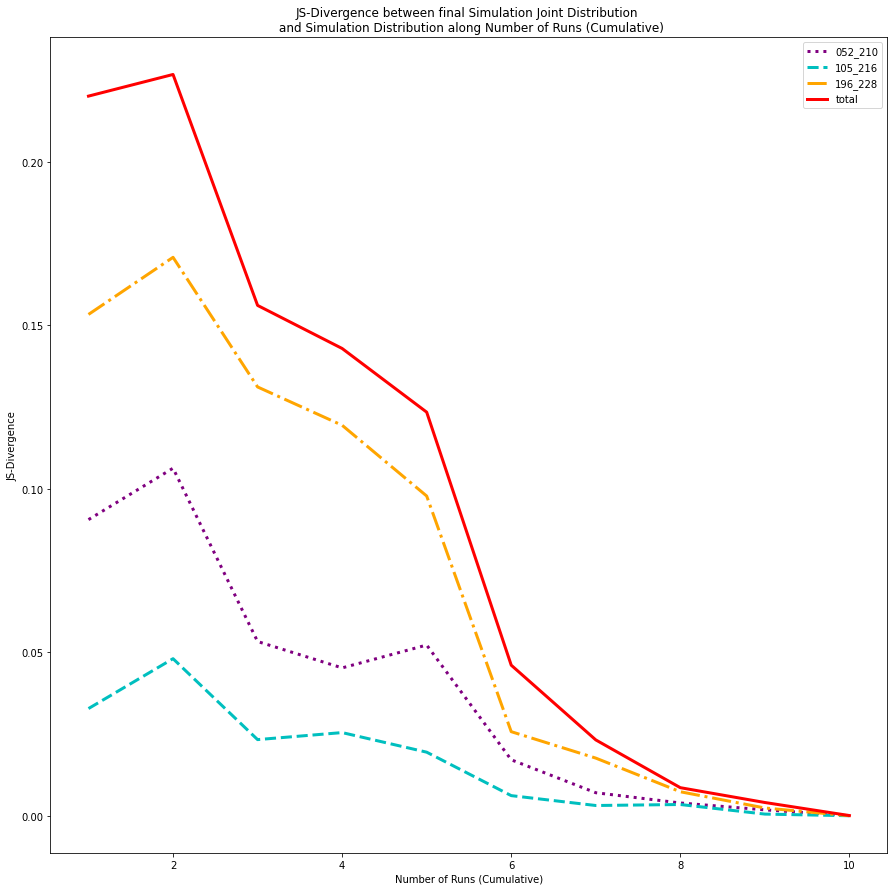

In [53]:
sim_data_by_run = {}
for run in range(1,11):
  sim_data_by_run[run] = np.zeros(shape=(nbins,nbins,nbins))
  for key in probs_through_runs[run]:   
    sim_data_by_run[run][bins.index(float(key[0:3])), bins.index(float(key[4:7])), bins.index(float(key[8:11]))] += probs_through_runs[run][key]
fig = plt.figure(figsize = (15,15))
waf.plot_js_along_runs(sim_data_by_run, simdata, sim_1D_dict, "Simulation")

#plt.savefig("JSdiv_by_runs_fig4_11_19.pdf")


# Comparing BRER and EESM distributions

In [54]:
brer_probs = np.load('Kasson lab/Polished Syntaxin Code/brer_joint_distribution.npy')

diffs = np.subtract(brer_probs, simdata)
top10 = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0} 
for d1 in range(nbins):
  for d2 in range(nbins):
    for d3 in range(nbins):
      diff = diffs[d1,d2,d3]
      vals = list(top10.values())
      keys = list(top10.keys())
      m = min(vals)
      if diff > m:
        if target_confs[d1,d2,d3] != 0:
          old = keys[vals.index(m)]
          top10.pop(old);
          key = str(bins[d1]) + ',' + str(bins[d2]) + ',' + str(bins[d3]) 
          top10[key] = diff

# json.dump(top10, open('most_different_structures.json', 'w'), indent = 2)

Text(0.5, 1.0, 'JS Divergence Between Experimental Convolution and EESM Ensemble by Run (Cumulative)')

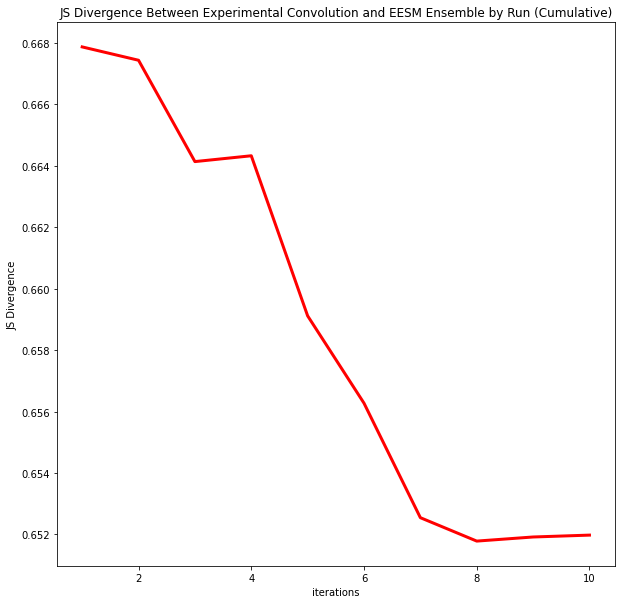

In [55]:
js_divs = []
for run in sim_data_by_run:
  deer_js_lst = []
  eesm_js_lst = []
  eesm_data = sim_data_by_run[run]
  runs = [1,2,3,4,5,6,7,8,9,10]
  for d1 in range(nbins):
    for d2 in range(nbins):
      for d3 in range(nbins):
        deer_js_lst.append(joint_exp[d1,d2,d3])
        eesm_js_lst.append(eesm_data[d1,d2,d3])
  js_divs.append(waf.JScalculator(deer_js_lst, eesm_js_lst))

fig = plt.figure(figsize = (10,10))
plt.plot(runs, js_divs, 'r', lw = 3)
plt.xlabel("iterations")
plt.ylabel("JS Divergence")
plt.title("JS Divergence Between Experimental Convolution and EESM Ensemble by Run (Cumulative)")

# plt.savefig("JSdiv_DEER_v_EESM_overall_11_19.pdf")


# Generating EESM figures by Run 

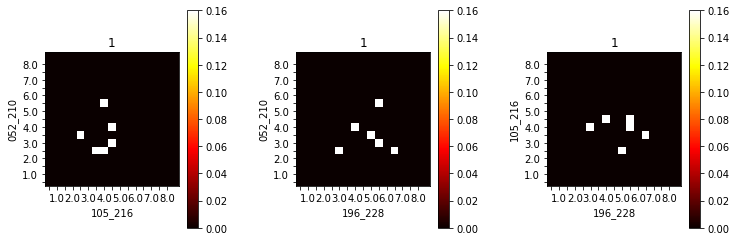

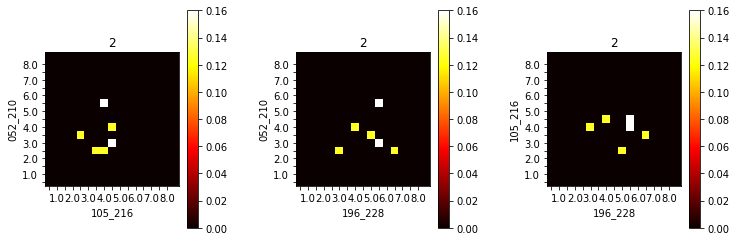

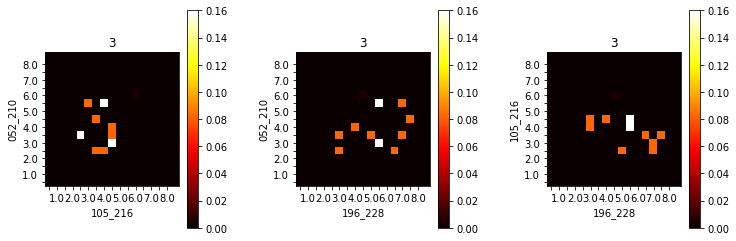

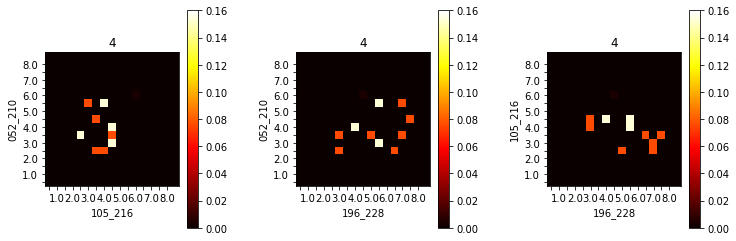

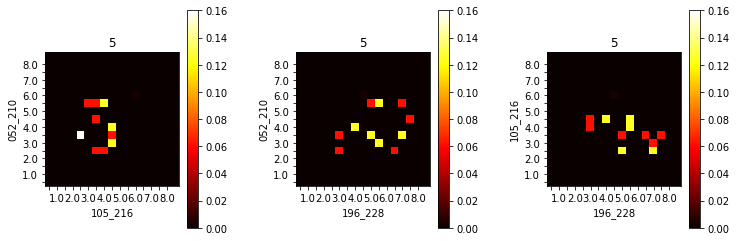

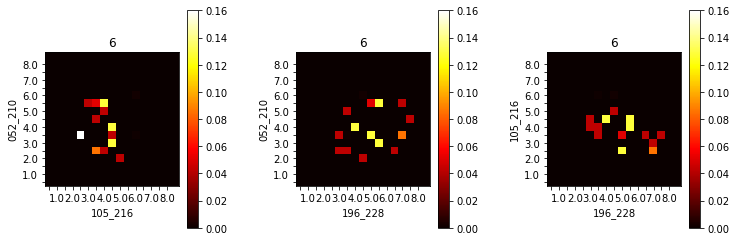

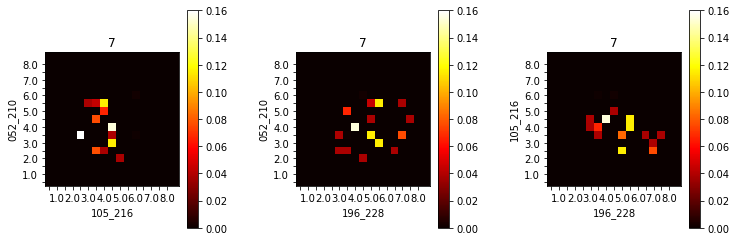

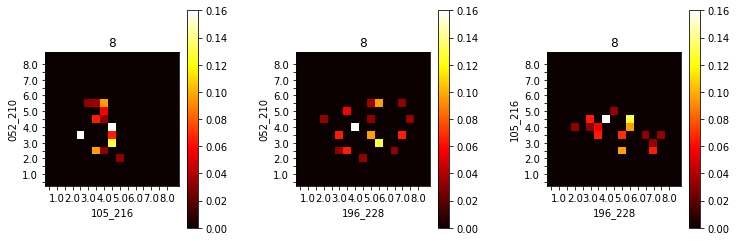

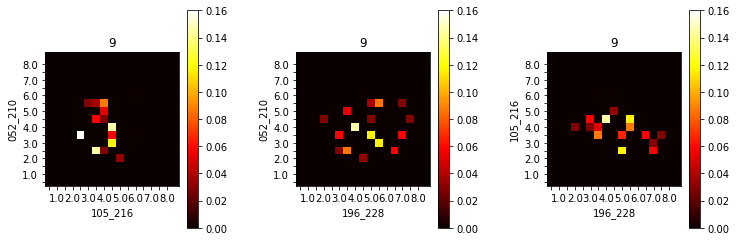

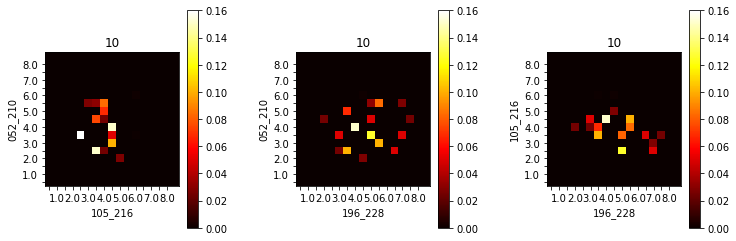

In [56]:
for run in sim_data_by_run:
  fig = plt.figure(figsize = (12,4))  
  spec = gridspec.GridSpec(ncols=3, nrows=1, figure = fig, wspace = 0.5)
  i = 0
  sim_2D_dict = waf.twoD_sum(sim_data_by_run[run])
  for key in sim_2D_dict:
    xlabel = key[9:]
    ylabel = key[0:7]
    fig.add_subplot(spec[0,i])
    plt.imshow(sim_2D_dict[key], 
        interpolation=None, 
        origin='lower', cmap='hot', vmax = 0.16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(run)
    plt.xticks(np.arange(16), ('','1.0', '','2.0', '','3.0','', '4.0','', '5.0','','6.0','','7.0','','8.0'))
    plt.yticks(np.arange(16), ('','1.0', '','2.0', '','3.0','', '4.0','', '5.0','','6.0','','7.0','','8.0'))
    i += 1
  # plt.savefig("EESM_2Ds_{}_run_11_19.pdf".format(run))


True

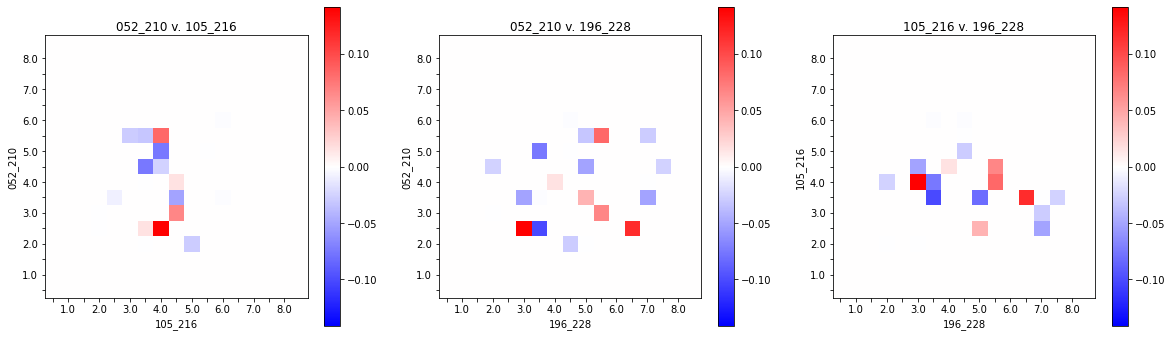

In [57]:
diffs = np.subtract(sim_data_by_run[1], simdata)
diff2D = waf.twoD_sum(diffs)
waf.make_map(diff2D, colorchoice = "bwr")

# plt.savefig("Sim1_SimFinal_Difference.pdf")

Generating Threshold Figures

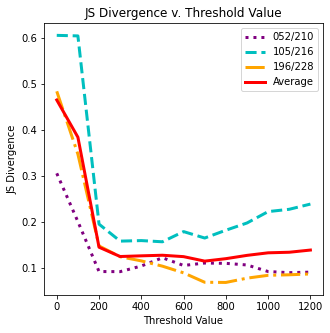

In [58]:
threshold_data = json.load(open("Kasson lab/Correlation Structure Paper figures/Figures + data for Nov 2020 update/threshold_values_data.json"))

fig = plt.figure(figsize = (5,5))
threshold_vals = threshold_data["threshold values"]
plt.plot(threshold_vals, threshold_data["052_210"],':', c = "purple", lw = 3)
plt.plot(threshold_vals, threshold_data["105_216"], '--c', lw = 3)
plt.plot(threshold_vals, threshold_data["196_228"], ls = '-.', c = 'orange', lw = 3)
plt.plot(threshold_vals, threshold_data["avg"], '-r', lw = 3)
plt.xlabel("Threshold Value")
plt.ylabel("JS Divergence")
plt.title("JS Divergence v. Threshold Value")
plt.legend(["052/210", "105/216", "196/228", "Average"])

# plt.savefig("Threshold_values_vs_JS_div.pdf")
# json.dump(js_divs_by_thr, open("threshold_values_data.json", "w"), indent =2)